# CRAG-ReAct: Intelligent Retrieval & Reasoning
## Robust Retrieval-Augmented Generation with Step-by-Step Reasoning

Welcome to this Jupyter notebook exploring cutting-edge techniques in artificial intelligence. We'll be diving into a powerful combination of two advanced approaches:

1. **Corrective Retrieval Augmented Generation (CRAG)**
2. **Reasoning+Acting (ReAct)**

![Local image](./assets/RAG.png "Flow Diagram")

Let's get started!

<small>

**SOURCES:**

[The paper](https://arxiv.org/abs/2210.03629) introduces ReAct, an approach that combines reasoning traces and task-specific actions in large language models (LLMs) to enhance their problem-solving capabilities. ReAct demonstrates improved performance, interpretability, and trustworthiness across various tasks, including question answering, fact verification, and interactive decision making, by allowing LLMs to generate reasoning steps and actions in an interleaved manner while interacting with external sources.


[The Corrective Retrieval Augmented Generation (CRAG)](https://arxiv.org/abs/2401.15884) is a proposed approach to improve the robustness of language model generation by incorporating a lightweight retrieval evaluator, large-scale web searches, and a decompose-then-recompose algorithm for retrieved documents. CRAG aims to enhance the performance of RAG-based approaches by assessing retrieval quality, augmenting results with web searches when necessary, and selectively focusing on key information while filtering out irrelevant content.
</small>


USER_AGENT environment variable not set, consider setting it to identify your requests.
I0000 00:00:1722429540.878135  622201 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache


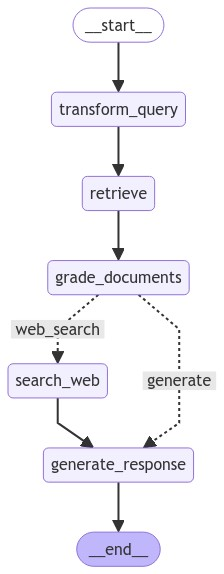

/Users/ben/GitHub/vectrix/.venv/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(
I0000 00:00:1722429542.365559  623585 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork


{'run_id': 'efdb82e3-3100-4291-8f10-080ffe0bdce1', 'type': 'progress', 'status': 'transform_query'}
{'run_id': '02ed3c17-aab0-4317-8dfa-03ccfdded2a0', 'type': 'progress', 'status': 'retrieve'}


I0000 00:00:1722429553.972871  622201 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork


{'run_id': '1d2ccd6b-d934-4be2-8651-64a8bad74fcc', 'type': 'progress', 'status': 'generate_response'}
{'run_id': '1d2ccd6b-d934-4be2-8651-64a8bad74fcc', 'type': 'response', 'chunk_content': 'Ben'}
{'run_id': '1d2ccd6b-d934-4be2-8651-64a8bad74fcc', 'type': 'response', 'chunk_content': ' Selleslag'}
{'run_id': '1d2ccd6b-d934-4be2-8651-64a8bad74fcc', 'type': 'response', 'chunk_content': 'h is a C'}
{'run_id': '1d2ccd6b-d934-4be2-8651-64a8bad74fcc', 'type': 'response', 'chunk_content': 'o-'}
{'run_id': '1d2ccd6b-d934-4be2-8651-64a8bad74fcc', 'type': 'response', 'chunk_content': 'Founder at V'}
{'run_id': '1d2ccd6b-d934-4be2-8651-64a8bad74fcc', 'type': 'response', 'chunk_content': 'ectr'}
{'run_id': '1d2ccd6b-d934-4be2-8651-64a8bad74fcc', 'type': 'response', 'chunk_content': 'ix. He has a'}
{'run_id': '1d2ccd6b-d934-4be2-8651-64a8bad74fcc', 'type': 'response', 'chunk_content': ' b'}
{'run_id': '1d2ccd6b-d934-4be2-8651-64a8bad74fcc', 'type': 'response', 'chunk_content': 'ackgrou'}
{'run_id':

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
from IPython.display import Image, display
from psycopg_pool import AsyncConnectionPool
from langchain_core.messages import HumanMessage
import uuid
from vectrix.graphs.basic_rag import RAGWorkflowGraph
from vectrix.streaming.processor import StreamProcessor
from vectrix.db.checkpointer import PostgresSaver

# Hide the rescources warning
import warnings
warnings.simplefilter("ignore", ResourceWarning)

os.environ["LANGCHAIN_TRACING_V2"] = "true"

# Enable langsmith tracing
DB_URI = os.getenv("DB_URI")

# Open a connection pool
# Create the pool without opening it
pool = AsyncConnectionPool(
    conninfo=DB_URI,
    max_size=20,
    open=False  # This prevents the pool from opening in the constructor
)

# Explicitly open the pool
await pool.open()

checkpointer = PostgresSaver(async_connection=pool)
await checkpointer.acreate_tables(pool)

# Create the config and a random thread it
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# Instatiate the graph 
demo_graph = RAGWorkflowGraph(DB_URI=DB_URI)
graph = demo_graph.create_graph(checkpointer=checkpointer)

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Set the input message
input = HumanMessage(content="Who is Ben Selleslagh?")

# Instanitate the stream processor
stream_processor = StreamProcessor(config)

# Run the stream and print the chunks
async for chunk in stream_processor.process_stream(graph, input):
    print(chunk)